In [31]:
import numpy as np
import tensorflow as tf
import os
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
from PIL import Image
from tensorflow.python.framework import ops
import math
import glob
from shutil import copyfile
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# import seaborn as sns

In [2]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1pOa0wYI0q0z7-XuWnYwBrO3io-J6bgFM'
id2='1Io_ZfD4ARm-vRBJoRURZ8d_lPkEbx6YU'
id3='1fWujUHcSCRzQzeUxqFGkrSBFwunGM1ic'

In [4]:
downloaded = drive.CreateFile({'id':id3})  #drive from PyDrive
downloaded.GetContentFile('cassava-disease.zip')

In [5]:
local_zip='./cassava-disease.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/')
zip_ref.close()

In [6]:
list_directory=os.listdir('./data/train/')
print(list_directory)

['healthy', 'cmd', 'cbb', 'cgm']


healthy


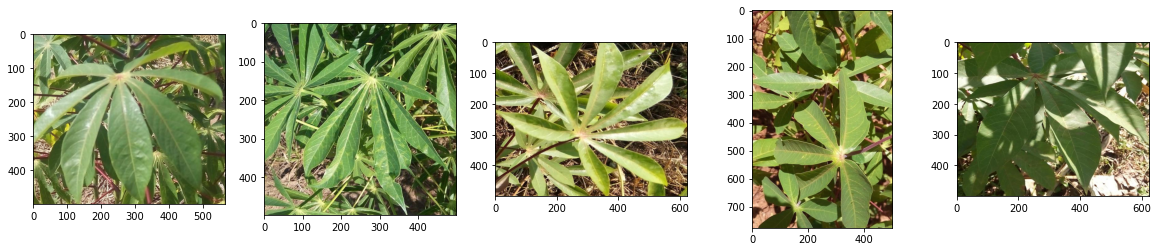

cmd


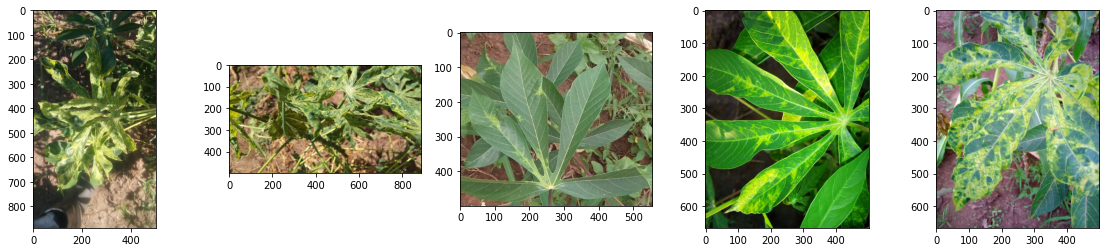

cbb


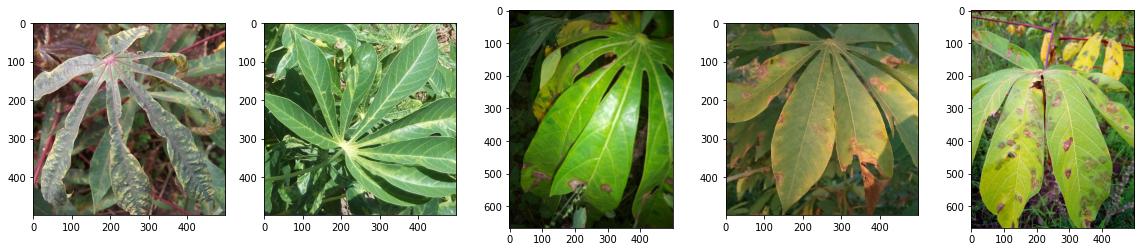

cgm


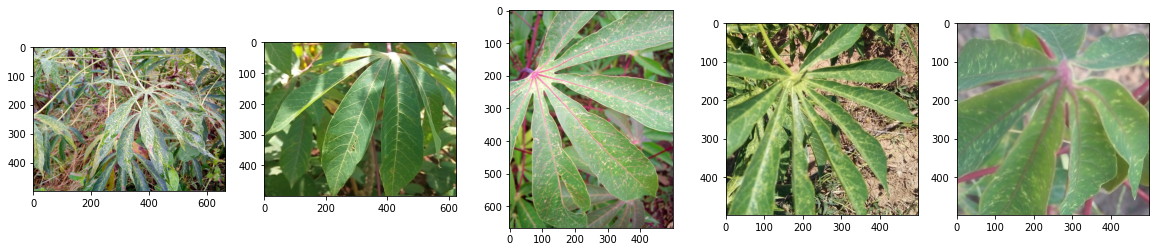

In [7]:
#checking image on directory
imdir='./data/train/'
for  images in list_directory:
  print(images)
  class_dir = os.path.join(imdir,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [9]:
findir='./siuu/train/'

# Image preprocessing

In [15]:
image_shape=150
datagen = ImageDataGenerator(
       rotation_range=40, # rotation
            width_shift_range=0.15, # horizontal shift
            height_shift_range=0.15, # vertical shift
            zoom_range=0.1, # zoom
            rescale=1.0/255,
            horizontal_flip=True, # horizontal flip
            vertical_flip=True, # vertical flip
            brightness_range=[0.75,1.25], # brightness
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 100

train_generator = datagen.flow_from_directory(
    imdir,
    target_size =(150,150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    imdir,
    target_size = (150,150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 3372 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


In [16]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['cbb', 'cgm', 'cmd', 'healthy']

In [17]:
train_generator.class_indices

{'cbb': 0, 'cgm': 1, 'cmd': 2, 'healthy': 3}

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 85%!")
callbacks = myCallback()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [20]:
base_model = tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
base_model.trainable = False

29097984/29084464 [==============================] - 0s 0us/step


In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                      restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint("Cassava_best_modelEffNetB3.h5",
                            save_best_only=True,
                            monitor = 'val_loss',
                            mode='min')

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)

In [22]:
try:
    with tf.device('/device:GPU:0'):
        inputs = tf.keras.layers.Input(shape=(image_size,image_size,3))
        x = base_model(inputs)
        x = tf.keras.layers.GaussianNoise(0.2)(x)
        # x=tf.keras.layers.Dropout(0.5)(x)
       
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(4,activation="softmax")(x)

        model4 = tf.keras.Model(inputs=[inputs],outputs=[outputs])

        model4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                      loss='categorical_crossentropy',
                      #loss=tfa.losses.SigmoidFocalCrossEntropy(),
                      metrics=['accuracy'])

        history=model4.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=[es,reduce_lr,checkpoint_cb]
                           )
except RuntimeError as e:
    print(e)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
34/34 [==============================] - 72s 2s/step - loss: 1.1170 - accuracy: 0.6041 - val_loss: 0.9248 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - 51s 1s/step - loss: 0.8635 - accuracy: 0.6720 - val_loss: 0.8420 - val_accuracy: 0.6576 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - 51s 1s/step - loss: 0.8016 - accuracy: 0.6833 - val_loss: 0.8048 - val_accuracy: 0.6754 - lr: 0.0010
Epoch 4/30
34/34 [==============================] - 50s 1s/step - loss: 0.7546 - accuracy: 0.7055 - val_loss: 0.7639 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 5/30
34/34 [==============================] - 51s 1s/step - loss: 0.7356 - accuracy: 0.7174 - val_loss: 0.7181 - val_accuracy: 0.7087 - lr: 0.0010
Epoch 6/30
34/34 [==============================] - 49s 1s/step - loss: 0.7160 - accuracy: 0.7248 - val_loss: 0.7426 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 7/30
34/34 [==============================] - 50s 1s/step - loss: 0.7032 - a

In [23]:
score_train = model4.evaluate(train_generator)
score_valid = model4.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy: (test)', score_valid[1])

9/9 [==============================] - 6s 663ms/step - loss: 0.6477 - accuracy: 0.7491
Accuracy (train):  0.7458481788635254
Accuracy: (test) 0.7491081953048706


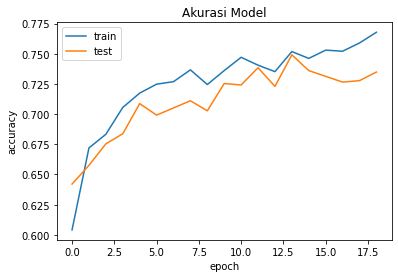

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

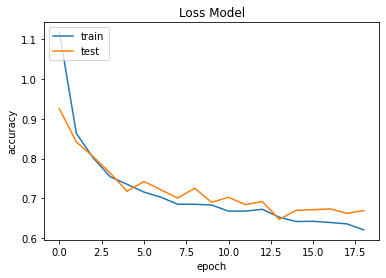

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
labels = []
for label in train_generator.class_indices:
  labels.append(label)
num_labels = len(labels)

print("Labels: {}".format(labels))
print("Num labels: {}".format(num_labels))

Labels: ['cbb', 'cgm', 'cmd', 'healthy']
Num labels: 4


In [32]:
y_test = validation_generator.classes
y_pred = model4.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


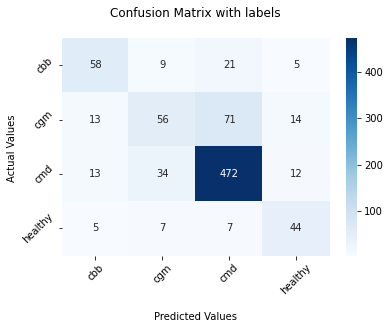

In [33]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels, rotation=45)
ax.yaxis.set_ticklabels(labels, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Save Model

In [ ]:
import tempfile
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model4.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



export_path = /tmp/1
total 3616
drwxr-xr-x 2 root root    4096 May 15 12:42 assets
-rw-r--r-- 1 root root  529186 May 15 12:42 keras_metadata.pb
-rw-r--r-- 1 root root 3160255 May 15 12:42 saved_model.pb
drwxr-xr-x 2 root root    4096 May 15 12:42 variables


In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = 'cassava_disease_v2_m3.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('cassava_disease_v3.txt', 'w') as f:
    f.write('\n'.join(label_types))

Saving Cassava-Bacterial-Blight-20.png to Cassava-Bacterial-Blight-20 (2).png
Cassava Bacterial Blight


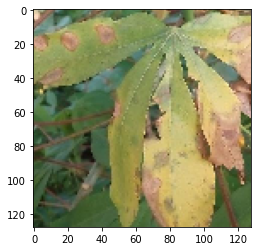

In [ ]:
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(image_size,image_size))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model4.predict(images, batch_size=100) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

if predicted_class_indices == 0:
    print('Cassava Bacterial Blight')

elif predicted_class_indices == 1:
  print('Cassava Green Mottle')
elif predicted_class_indices == 2:
  print('cassava mosaic disease ')
elif predicted_class_indices == 3:
  print('Healthy')
else:
  print('')

# Model 2

In [34]:
model2 = Sequential()
    # initialize the model with input shape as (224,224,3)
model2.add(tf.keras.applications.DenseNet121(input_shape = (image_shape, image_shape, 3), include_top = False, weights = 'imagenet' ))
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model2.add(Dropout(0.7))
model2.add(Dense(32, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model2.add(Dropout(0.7))
model2.add(Dense(4, activation = 'softmax'))

In [35]:
EPOCHS = 5
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [36]:
model2.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [37]:
 history = model2.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=[es,reduce_lr,checkpoint_cb]
                            )

Epoch 1/30
33/33 [==============================] - 76s 2s/step - loss: 2.0287 - accuracy: 0.3368 - val_loss: 1.1167 - val_accuracy: 0.6650 - lr: 2.0000e-04
Epoch 2/30
33/33 [==============================] - 54s 2s/step - loss: 1.3534 - accuracy: 0.4358 - val_loss: 1.0352 - val_accuracy: 0.6662 - lr: 2.0000e-04
Epoch 3/30
33/33 [==============================] - 54s 2s/step - loss: 1.2336 - accuracy: 0.4930 - val_loss: 0.9721 - val_accuracy: 0.6975 - lr: 2.0000e-04
Epoch 4/30
33/33 [==============================] - 55s 2s/step - loss: 1.1729 - accuracy: 0.5171 - val_loss: 0.9442 - val_accuracy: 0.7188 - lr: 2.0000e-04
Epoch 5/30
33/33 [==============================] - 54s 2s/step - loss: 1.0784 - accuracy: 0.5535 - val_loss: 0.7969 - val_accuracy: 0.7300 - lr: 2.0000e-04
Epoch 6/30
33/33 [==============================] - 54s 2s/step - loss: 1.0241 - accuracy: 0.5908 - val_loss: 0.7354 - val_accuracy: 0.7325 - lr: 2.0000e-04
Epoch 7/30
33/33 [==============================] - 54s 2s

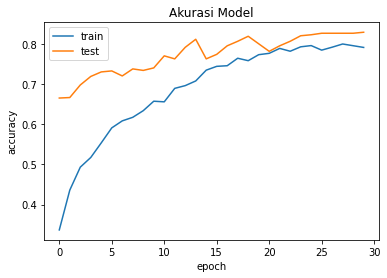

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

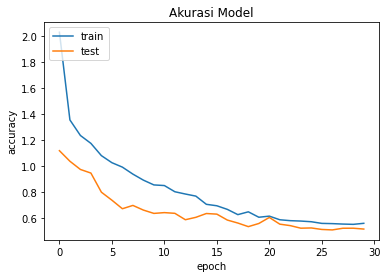

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [40]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


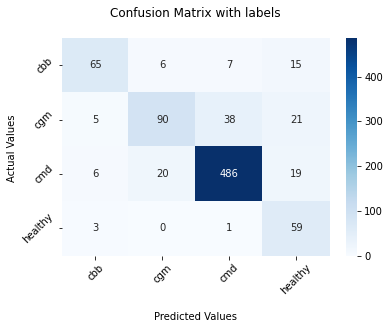

In [41]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels, rotation=45)
ax.yaxis.set_ticklabels(labels, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Model 3 with generated data

In [ ]:
downloaded2= drive.CreateFile({'id':id2})  #drive from PyDrive
downloaded2.GetContentFile('data.zip')

In [ ]:
local_zip='./data.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./dataset_siap/')
zip_ref.close()

In [ ]:
list_directory=os.listdir('./dataset_siap/train/')
print(list_directory)
imdir='./dataset_siap/train/'

['cbb', 'healthy', 'cmd', 'cbsd']


In [45]:
diseases=('cbb','cgm','cmd','healthy')

In [46]:
def load_image_array(alldata_dir, disease):
  temp_dis_dir = os.path.join(imdir, disease)
  temp_files = os.listdir(temp_dis_dir)
  temp_paths = [os.path.join(temp_dis_dir, file) for file in temp_files]
  temp_imgs = [read_image(file) for file in temp_paths]

  return np.array(temp_imgs)

def image_pixel_normalization(image):
  """
  transform image to same size without cropping the image
  e.g. image size : (200, 600) => (600, 600)
  """
  h, w, _ = image.shape

  norm_size = h if h > w else w
  
  add_h = norm_size - h
  add_w = norm_size - w 
  
  start_add_h = add_h // 2
  start_add_w = add_w // 2

  new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
  new_img[start_add_h:start_add_h + h, start_add_w:start_add_w + w, :] = image
  
  return new_img

def preprocessing(image):
  """
  preprocessing image including size normalization and resize image
  """
  img = image_pixel_normalization(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)

def read_image(image_file):
  img = cv2.imread(image_file)
  img = preprocessing(img)
  return np.array(img)

In [47]:
disease_imgs = {}

for disease in diseases:
  disease_imgs[disease] = load_image_array(imdir, disease)
  print(disease, "done") 

disease_imgs.keys()

cbb done
cgm done
cmd done
healthy done


dict_keys(['cbb', 'cgm', 'cmd', 'healthy'])

In [48]:
disease_imgs['cbb'].shape

(466, 300, 300, 3)

In [49]:
shutil.rmtree('siuu/train', ignore_errors=True)
finaldata_dir = "./siuu/train/"

In [50]:
os.mkdir(finaldata_dir)
for disease in diseases:
  os.mkdir(os.path.join(finaldata_dir, disease))

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [53]:
datagen = ImageDataGenerator(
            rotation_range=40, # rotation
            # width_shift_range=0.15, # horizontal shift
            # height_shift_range=0.15, # vertical shift
            # zoom_range=0.1, # zoom
            # horizontal_flip=True, # horizontal flip
            # vertical_flip=True, # vertical flip
            # brightness_range=[0.75,1.25], # brightness
          )

def generate_image(datagen, data, amount, savepath=None):
  # prepare iterator
  it = datagen.flow(
        data, 
        batch_size=1, 
        save_to_dir=savepath,
        save_prefix='',
        save_format='png',
      )
  
  # generate samples and plot
  for i in range(amount):
    batch = it.next()
    image = batch[0].astype('uint8')

In [54]:
amount = 1000

for idx, disease in enumerate(diseases):
  save_path = os.path.join(finaldata_dir, disease)
  generate_image(datagen, disease_imgs[disease], amount, save_path)
  print("{} (done) : {}".format(disease, len(os.listdir(save_path))))

cbb (done) : 1000
cgm (done) : 1000
cmd (done) : 1000
healthy (done) : 1000


In [55]:
!zip -r finaldata.zip siuu/train/

  adding: siuu/train/ (stored 0%)
  adding: siuu/train/healthy/ (stored 0%)
  adding: siuu/train/healthy/_113_4124.png (deflated 0%)
  adding: siuu/train/healthy/_158_3643.png (deflated 0%)
  adding: siuu/train/healthy/_256_9790.png (deflated 0%)
  adding: siuu/train/healthy/_224_5623.png (deflated 0%)
  adding: siuu/train/healthy/_138_589.png (deflated 0%)
  adding: siuu/train/healthy/_151_6719.png (deflated 0%)
  adding: siuu/train/healthy/_31_3990.png (deflated 0%)
  adding: siuu/train/healthy/_96_1659.png (deflated 0%)
  adding: siuu/train/healthy/_177_189.png (deflated 0%)
  adding: siuu/train/healthy/_207_1996.png (deflated 0%)
  adding: siuu/train/healthy/_238_6954.png (deflated 0%)
  adding: siuu/train/healthy/_108_4695.png (deflated 1%)
  adding: siuu/train/healthy/_205_5199.png (deflated 0%)
  adding: siuu/train/healthy/_43_8828.png (deflated 0%)
  adding: siuu/train/healthy/_112_9140.png (deflated 0%)
  adding: siuu/train/healthy/_106_1458.png (deflated 0%)
  adding: siuu/tr

healthy


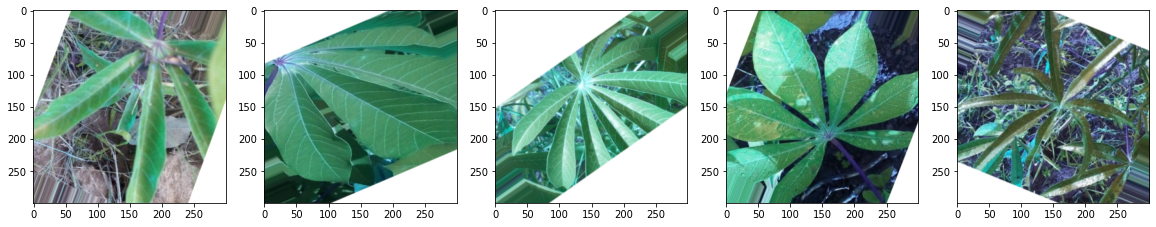

cmd


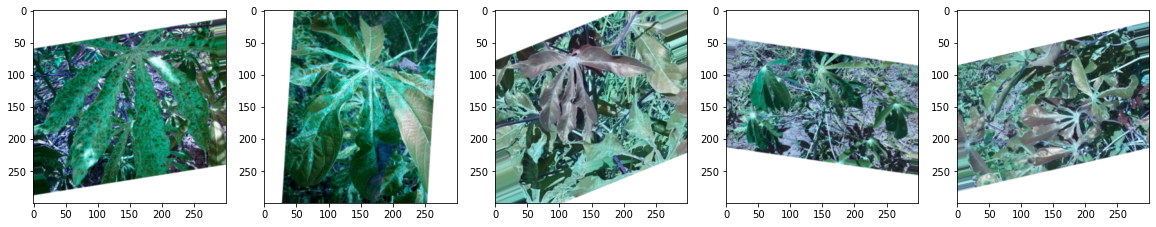

cbb


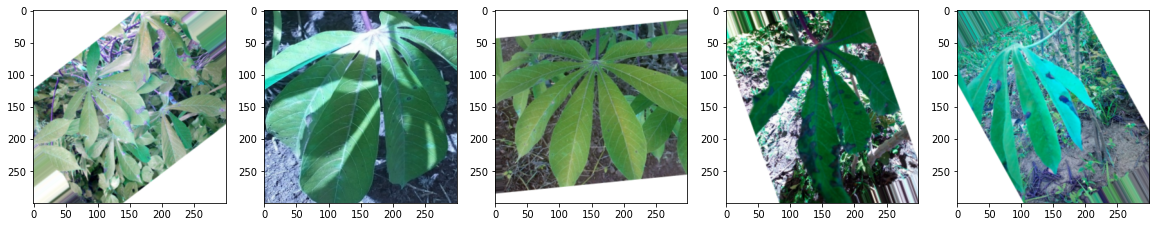

cgm


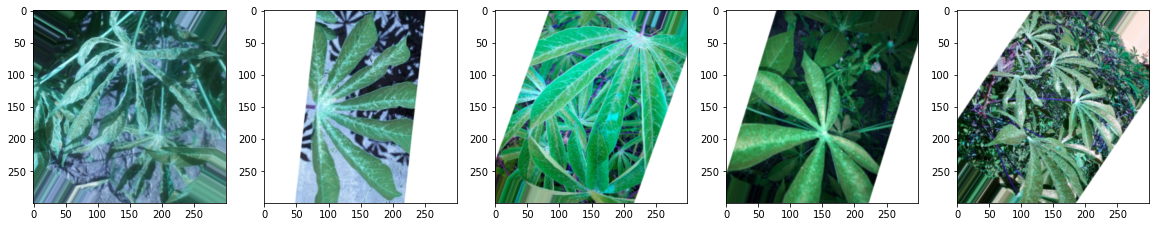

In [56]:
#checking image on directory
findir='./siuu/train/'
for  images in list_directory:
  print(images)
  class_dir = os.path.join(findir,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [98]:
image_shape=224
datagen = ImageDataGenerator(
       rotation_range=40, # rotation
            width_shift_range=0.15, # horizontal shift
            height_shift_range=0.15, # vertical shift
            zoom_range=0.1, # zoom
            rescale=1.0/255,
            horizontal_flip=True, # horizontal flip
            vertical_flip=True, # vertical flip
            brightness_range=[0.75,1.25], # brightness
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 100

train_generator = datagen.flow_from_directory(
    findir,
    target_size =(image_shape,image_shape),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    findir,
    target_size = (image_shape,image_shape),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [99]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['cbb', 'cgm', 'cmd', 'healthy']

In [100]:
base_model = tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',input_shape=(image_shape,image_shape,3))
base_model.trainable = False

In [101]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [102]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                      restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint("Cassava_best_modelEffNetB3.h5",
                            save_best_only=True,
                            monitor = 'val_loss',
                            mode='min')

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)

In [103]:
try:
    with tf.device('/device:GPU:0'):
        inputs = tf.keras.layers.Input(shape=(image_shape,image_shape,3))
        x = base_model(inputs)
        x = tf.keras.layers.GaussianNoise(0.2)(x)
        # x=tf.keras.layers.Dropout(0.5)(x)
       
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(4,activation="softmax")(x)

        model4 = tf.keras.Model(inputs=[inputs],outputs=[outputs])

        model4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                      loss='categorical_crossentropy',
                      #loss=tfa.losses.SigmoidFocalCrossEntropy(),
                      metrics=['accuracy'])

        history=model4.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=[es,reduce_lr,checkpoint_cb]
                           )
except RuntimeError as e:
    print(e)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
32/32 [==============================] - 73s 2s/step - loss: 1.3485 - accuracy: 0.3837 - val_loss: 1.1213 - val_accuracy: 0.5225 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - 63s 2s/step - loss: 1.0759 - accuracy: 0.5503 - val_loss: 0.9758 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - 63s 2s/step - loss: 0.9638 - accuracy: 0.6116 - val_loss: 0.9120 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 4/30
32/32 [==============================] - 63s 2s/step - loss: 0.9021 - accuracy: 0.6409 - val_loss: 0.8661 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 5/30
32/32 [==============================] - 62s 2s/step - loss: 0.8616 - accuracy: 0.6550 - val_loss: 0.8434 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 6/30
32/32 [==============================] - 63s 2s/step - loss: 0.8292 - accuracy: 0.6681 - val_loss: 0.8227 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 7/30
32/32 [==============================] - 63s 2s/step - loss: 0.8065 - a

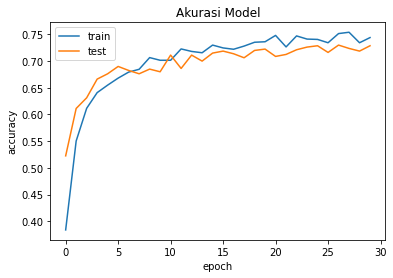

In [104]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

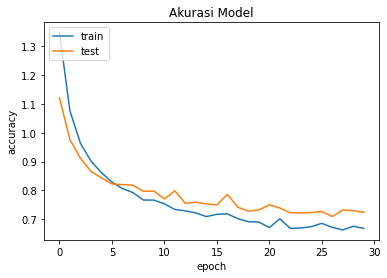

In [105]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [106]:
y_test = validation_generator.classes
y_pred = model4.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


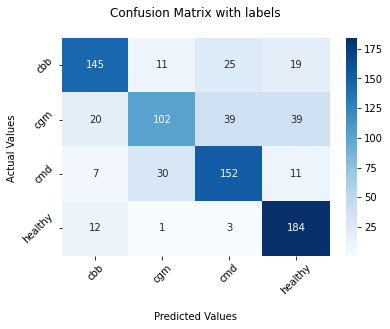

In [107]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels, rotation=45)
ax.yaxis.set_ticklabels(labels, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Model 3

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [121]:
model3 = Sequential()
    # initialize the model with input shape as (224,224,3)
model3.add(tf.keras.applications.DenseNet121(input_shape = (image_shape, image_shape, 3), include_top = False, weights = 'imagenet' ))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dense(256, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model3.add(Dropout(0.7))
model3.add(Dense(32, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model3.add(Dropout(0.7))
model3.add(Dense(4, activation = 'softmax'))

In [91]:

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [122]:
model3.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [123]:
 history = model3.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 50,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=[es,reduce_lr,checkpoint_cb]
                            )

Epoch 1/50
32/32 [==============================] - 90s 2s/step - loss: 1.9489 - accuracy: 0.2669 - val_loss: 1.3084 - val_accuracy: 0.4350 - lr: 2.0000e-04
Epoch 2/50
32/32 [==============================] - 73s 2s/step - loss: 1.4192 - accuracy: 0.3419 - val_loss: 1.2748 - val_accuracy: 0.5337 - lr: 2.0000e-04
Epoch 3/50
32/32 [==============================] - 73s 2s/step - loss: 1.2754 - accuracy: 0.4081 - val_loss: 1.1130 - val_accuracy: 0.5850 - lr: 2.0000e-04
Epoch 4/50
32/32 [==============================] - 72s 2s/step - loss: 1.1246 - accuracy: 0.5031 - val_loss: 0.8681 - val_accuracy: 0.6975 - lr: 2.0000e-04
Epoch 5/50
32/32 [==============================] - 73s 2s/step - loss: 1.0039 - accuracy: 0.5781 - val_loss: 0.7515 - val_accuracy: 0.7212 - lr: 2.0000e-04
Epoch 6/50
32/32 [==============================] - 73s 2s/step - loss: 0.9005 - accuracy: 0.6313 - val_loss: 0.6141 - val_accuracy: 0.7763 - lr: 2.0000e-04
Epoch 7/50
32/32 [==============================] - 73s 2s

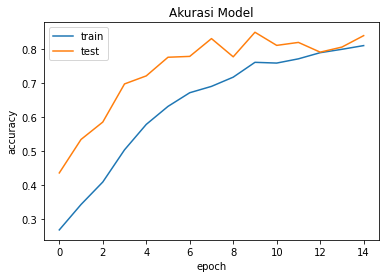

In [124]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

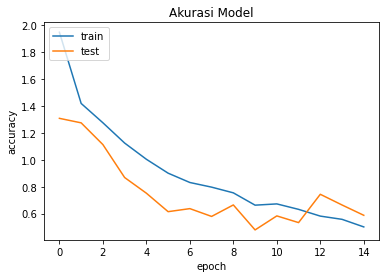

In [125]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [127]:
model3.evaluate(train_generator)

32/32 [==============================] - 59s 2s/step - loss: 0.4035 - accuracy: 0.8719


[0.4035463333129883, 0.871874988079071]

In [129]:
model3.evaluate(validation_generator)

8/8 [==============================] - 6s 720ms/step - loss: 0.4783 - accuracy: 0.8500


[0.47833365201950073, 0.8500000238418579]

In [132]:
y_test = validation_generator.classes
y_pred = model3.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


# See Confussion Matrix

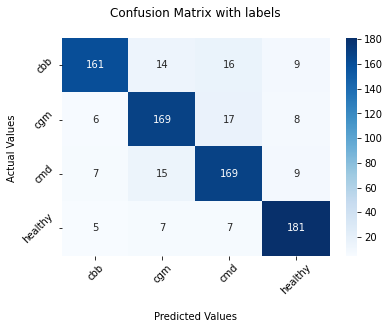

In [133]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)


ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels, rotation=45)
ax.yaxis.set_ticklabels(labels, rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Test predict for model 3

Saving train-cbb-2.jpg to train-cbb-2.jpg
Cassava Bacterial Blight


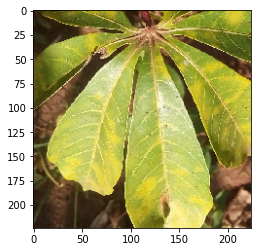

In [145]:
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model3.predict(images, batch_size=100) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

if predicted_class_indices == 0:
    print('Cassava Bacterial Blight')

elif predicted_class_indices == 1:
  print('Cassava Green Mottle')
elif predicted_class_indices == 2:
  print('cassava mosaic disease ')
elif predicted_class_indices == 3:
  print('Healthy')
else:
  print('')

# Save Model 3

In [146]:
import tempfile
MODEL_DIR = tempfile.gettempdir()

version = 3

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model2.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/3/assets

export_path = /tmp/3
total 32
drwxr-xr-x 2 root root  4096 May 18 15:14 assets
-rw-r--r-- 1 root root  1102 May 18 15:14 keras_metadata.pb
-rw-r--r-- 1 root root 16811 May 18 15:14 saved_model.pb
drwxr-xr-x 2 root root  4096 May 18 15:14 variables


In [147]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = 'cassava_disease_v2_m3(best).tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('cassava_disease_v3(best).txt', 'w') as f:
    f.write('\n'.join(label_types))